<a href="https://colab.research.google.com/github/AnandSaumya/Airlines-Customer-Satisfaction/blob/main/Airlines_Customer_Satisfaction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

$\huge{\textbf{Analyzing Airlines Customer Data}}$



---


$\textit{This is a self-paced project focused on analyzing airlines customer data to understand the dynamics behind the customer satisfaction and the revenue generated.}$

The dataset of this project has been taken from Kaggle. Originally, this dataset was given to a tech competition participants from an airline. To ensure sensitive data protection, the names have been changed.

# $\text{Table of Content}$

1. Data Preparation
2. Exploratory Data Analysis

# Data Preparation



---

The following steps have been taken up to prepare the data for analysis:



1.   Data is loaded from personal GitHub
2.   Data is checked for nulls and conflicting data types to ensure uniformity.
3.   Data is cleaned by removing/imputing nulls by general guess.



In [26]:
# Import the necessary libraries
import pandas as pd
import numpy as np
import scipy as sc
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px

In [27]:
# Load the dataset
df = pd.read_csv('https://raw.githubusercontent.com/AnandSaumya/Airlines-Customer-Satisfaction/main/Dataset/Invistico_Airline.csv')  # When trying to load the datafile from GitHub: 1) Replace https://github.com/ with https://raw.githubusercontent.com/. and 2) Remove /blob/ from the URL.

In [28]:
# View a couple of rows of the dataset
df.head()

,satisfaction,Gender,Customer Type,Age,Type of Travel,Class,Flight Distance,Seat comfort,Departure/Arrival time convenient,Food and drink,...,Online support,Ease of Online booking,On-board service,Leg room service,Baggage handling,Checkin service,Cleanliness,Online boarding,Departure Delay in Minutes,Arrival Delay in Minutes
0,satisfied,Female,Loyal Customer,65,Personal Travel,Eco,265,0,0,0,...,2,3,3,0,3,5,3,2,0,0.0
1,satisfied,Male,Loyal Customer,47,Personal Travel,Business,2464,0,0,0,...,2,3,4,4,4,2,3,2,310,305.0
2,satisfied,Female,Loyal Customer,15,Personal Travel,Eco,2138,0,0,0,...,2,2,3,3,4,4,4,2,0,0.0
3,satisfied,Female,Loyal Customer,60,Personal Travel,Eco,623,0,0,0,...,3,1,1,0,1,4,1,3,0,0.0
4,satisfied,Female,Loyal Customer,70,Personal Travel,Eco,354,0,0,0,...,4,2,2,0,2,4,2,5,0,0.0


In [29]:
# View what the datatype is of the various columns in the dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 129880 entries, 0 to 129879
Data columns (total 23 columns):
 #   Column                             Non-Null Count   Dtype  
---  ------                             --------------   -----  
 0   satisfaction                       129880 non-null  object 
 1   Gender                             129880 non-null  object 
 2   Customer Type                      129880 non-null  object 
 3   Age                                129880 non-null  int64  
 4   Type of Travel                     129880 non-null  object 
 5   Class                              129880 non-null  object 
 6   Flight Distance                    129880 non-null  int64  
 7   Seat comfort                       129880 non-null  int64  
 8   Departure/Arrival time convenient  129880 non-null  int64  
 9   Food and drink                     129880 non-null  int64  
 10  Gate location                      129880 non-null  int64  
 11  Inflight wifi service              1298

In [30]:
# Get the number of nulls in each column
df.isnull().sum()

,0
satisfaction,0
Gender,0
Customer Type,0
Age,0
Type of Travel,0
Class,0
Flight Distance,0
Seat comfort,0
Departure/Arrival time convenient,0
Food and drink,0


In [31]:
mean_of_arrival_delay=np.round(np.mean(df['Arrival Delay in Minutes']),1)
mean_of_arrival_delay

15.1

In [32]:
# Imputing the missing values by adding the departure delay and average of arrival delay UNDER THE ASSUMPTION that the airline wasn't able to recover the lost time in departure delay.
df.loc[df['Arrival Delay in Minutes'].isnull(), 'Arrival Delay in Minutes'] = (df['Departure Delay in Minutes'] + mean_of_arrival_delay)

In [33]:
# Making sure no nulls are left
df.isnull().sum()

,0
satisfaction,0
Gender,0
Customer Type,0
Age,0
Type of Travel,0
Class,0
Flight Distance,0
Seat comfort,0
Departure/Arrival time convenient,0
Food and drink,0


# Exploratory Data Analysis

<ipython-input-34-278cc53f0cd7>:4: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




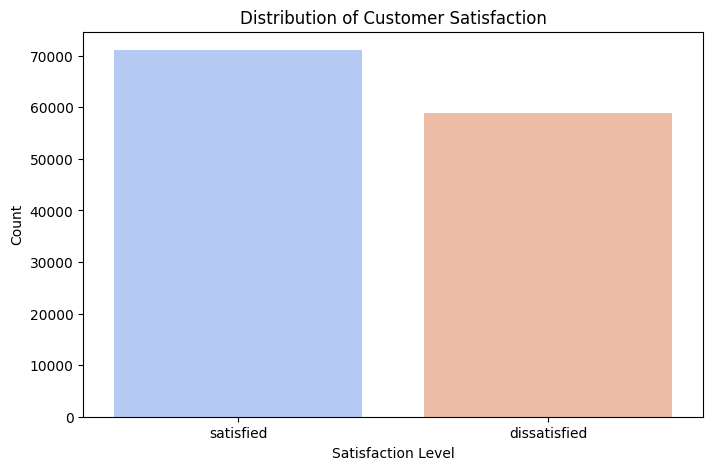

In [34]:
# Understanding the customer satisfaction distribution

plt.figure(figsize=(8, 5))
sns.countplot(x='satisfaction', data=df, palette='coolwarm')
plt.title('Distribution of Customer Satisfaction')
plt.xlabel('Satisfaction Level')
plt.ylabel('Count')
plt.show()

The above chart gives a really important inisght into the satisfaction level of the customers, as it can be clearly seen that the count of `satisfied` customers is significantly higher than the `disstatisfied` customers, helping understand the confidence level of our customers in our services.


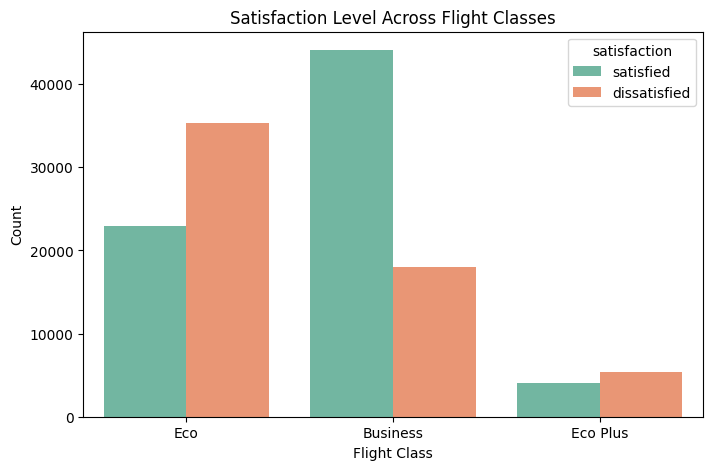

satisfaction,dissatisfied,satisfied
Class,,
Business,18065,44095
Eco,35336,22973
Eco Plus,5392,4019


In [35]:
# Flight Class v/s Satisfaction
plt.figure(figsize=(8, 5))
sns.countplot(x='Class', hue='satisfaction', data=df, palette='Set2')
plt.title('Satisfaction Level Across Flight Classes')
plt.xlabel('Flight Class')
plt.ylabel('Count')
plt.show()

# Numerical values
class_satisfaction_counts = df.groupby(['Class', 'satisfaction']).size().unstack(fill_value=0)
class_satisfaction_counts

In [36]:
# Calculate the ratio of satisfied to dissatisfied customers for each class
class_satisfaction_ratios = class_satisfaction_counts['satisfied'] / class_satisfaction_counts['dissatisfied']

# Print the ratios
business_ratio=np.round(class_satisfaction_ratios.loc['Business'],2)
print("The Business class ratio of satisfied to dissatisfied customers is ",business_ratio)

eco_ratio=np.round(class_satisfaction_ratios.loc['Eco'],2)
print("The Economy class ratio of satisfied to dissatisfied customers is ",eco_ratio)

eco_plus_ratio=np.round(class_satisfaction_ratios.loc['Eco Plus'],2)
print("The Economy Plus class ratio of satisfied to dissatisfied customers is ",eco_plus_ratio)

The Business class ratio of satisfied to dissatisfied customers is  2.44
The Economy class ratio of satisfied to dissatisfied customers is  0.65
The Economy Plus class ratio of satisfied to dissatisfied customers is  0.75


From above it can be seen that the ratio of satisfied to dissatisfied customers is the highest in Business Class ratio whereas, in the case of Economy and Economy Plus it can be seen that the ratio is pretty close.

If there was additional information available regarding revenue, occupancy rates, operating costs for each fare class, and per square meter for each cabin space, we could better compare the three classes and see increasing or decreasing the space in which compartment would be the most profitable.

In [37]:
# Aggregate the data to get satisfaction counts by Gender
satisfaction_counts = df.groupby(['Gender', 'satisfaction']).size().reset_index(name='Count')

# Create an interactive bar chart
fig = px.bar(
    satisfaction_counts,
    x='Gender',
    y='Count',
    color='satisfaction',
    barmode='group',
    title='Satisfaction Level vs Gender',
    labels={'Count': 'Number of Customers', 'Gender': 'Gender', 'satisfaction': 'Satisfaction Level'},
    hover_data={'Count': True}  # This enables the hover information,
)

# Show the interactive plot
fig.show()

# Show the satisfaction counts in tabular form
satisfaction_counts

,Gender,satisfaction,Count
0,Female,dissatisfied,22971
1,Female,satisfied,42928
2,Male,dissatisfied,35822
3,Male,satisfied,28159


From the above chart, we can see that as per the dataset, the satisfaction level in women is relatively higher than that of men. The dataset points that, overall, the male gender identifying customers are more dissatisfied.